# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [68]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

## 4. What is the relation between US cases of Colony Collapse Disorder and the main factors of CCD?

Arthur

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Calfornia has been producing more than 80% of the world almond production for many years, and is the only state that harvests almonds. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11), [[3]](http://www.almonds.com/sites/default/files/Almond_Almanac_2018_F_revised.pdf). The almond tree is one of the many crop that require cross-pollination for it to bear fruits. It is simple, no pollinators, no almonds. Thus, pollinators and especially honey bees play a central and vital role in growing almonds. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421). Almond growers need to play hand in hand with bee keepers in order to ensure plentiful harvests. We first show the current contribution of bees to this industry, then we try to look into the effect of bee on the productivity from the 00's to 2017.


2006-7 Bee loss
since 2014 program for [HONEY BEE BEST MANAGEMENT PRACTICES](http://www.almonds.com/pollination)

### 5.1 Loading Datasets
#### 5.1.1 Loading almond production dataset
This is a subset of the data from the [USDA](https://quickstats.nass.usda.gov/) dataset

In [178]:
california_almond = pd.read_excel('data/california_USDA_almond.xlsx', skiprows=[22])
california_almond.tail()

,year,bearing,non_bearing,yield_per_acre,production,price_per_pound,value_of_production
16,2013,880000,120000,2280,2010,3.21,6384690
17,2014,930000,170000,2010,1870,4.00,7388000
18,2015,950000,240000,2000,1900,3.13,5868750
19,2016,970000,300000,2210,2140,2.44,5052460
20,2017,1030000,330000,2200,2270,2.53,5603950


Some notes on the above datasets:
- bearing, non_bearing are in acres => want to convert into hectares (10'000 $m^2$)
- yield per acre is in pounds => want to convert into kg/hectares
- production is in million of pounds => want to convert into kg
- price is in \$/pound => want to convert into kg
- value of production is thousands of \$

In [179]:
HECTARE_PER_ACRE = 0.404686
KG_PER_POUND = 0.453592

# Convertion acre => hectare
california_almond.bearing *= HECTARE_PER_ACRE
california_almond.non_bearing *= HECTARE_PER_ACRE
california_almond.yield_per_acre /= HECTARE_PER_ACRE

# Convertion pound => kg
california_almond.yield_per_acre *= KG_PER_POUND
california_almond.production *= KG_PER_POUND
california_almond.price_per_pound /= KG_PER_POUND

In [180]:
# Add total harvested area
california_almond['total'] = california_almond.bearing + california_almond.non_bearing

#### 5.1.2 Loading the rest of the almond dataset from USDA
Here we only keep some columns from the dataset that are containing the relevant information of the type:
- Program: Survey (usually every year) / Census (1992, 2012, 2017)
- Time Data: Year, Period
- Geo Data: Geo Level, State, Region
- Field descriptors: Data Item, Domain, Domain Category
- Value field: Value

In [235]:
col_to_keep_almond = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Region', 'Data Item', 'Value', 'Domain', 'Domain Category']
almond_df = pd.read_csv('data/USDA_almond.csv', usecols=col_to_keep_almond)

#### 5.1.3 Loading bee inventory from USDA
We keep columns in a similar fashion as in 5.1.2

In [226]:
col_to_keep_bee = ['Program' , 'Year', 'Period', 'Geo Level', 'State', 'Data Item', 'Value', 'Domain', 'Domain Category']
bee_colony_df = pd.read_csv('data/USDA_bee_colony.csv', usecols=col_to_keep_bee)
bee_colony_df.Value = bee_colony_df.Value.apply(parse_number)

### 5.2 Contribution of bees
We first look into the effect of pollination. We only have limited data from 2015-2017. We can explore it in 5 directions shown in the list below.

In [4]:
pollination = ['ALMONDS, HONEY BEE POLLINATION - ACRES POLLINATED, PAID BASIS',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / ACRE',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN $ / COLONY',
               'ALMONDS, HONEY BEE POLLINATION - POLLINATION, MEASURED IN COLONIES',
               'ALMONDS, HONEY BEE POLLINATION - VALUE OF POLLINATION, MEASURED IN $']

In [225]:
def parse_number(number):
    """ Helper to parse american style number to int """
    if type(number) is np.int:
        return number
    if re.search(r'[DZ]', number):
        return 0
    try:
        return int(re.sub(r"[,'_]", "", number))
    except:
        print('Error while parsing:', number)
        return np.nan

In [98]:
pollination_df = almond_df[almond_df['Data Item'].isin(pollination)]\
                 .drop(columns=['Program', 'Period', 'Geo Level', 'State', 'Domain', 'Domain Category'])\
                 .copy()
pollination_df.Value = pollination_df.Value.apply(parse_number)

pollination_df['Data Item'] = pollination_df['Data Item'].apply(lambda x: x.lstrip('ALMONDS, HONEY BEE POLLINATION')[2:])

In [172]:
pollination_pivot = pollination_df.pivot(index='Year', columns='Data Item', values='Value')
pollination_pivot

Data Item,"ACRES POLLINATED, PAID BASIS","POLLINATION, MEASURED IN $ / ACRE","POLLINATION, MEASURED IN $ / COLONY","POLLINATION, MEASURED IN COLONIES","VALUE OF POLLINATION, MEASURED IN $"
Year,,,,,
2015,921200,313,165,1760000,290400000
2016,921400,287,167,1590000,265530000
2017,928600,272,171,1480000,253080000


In [185]:
(pollination_pivot['ACRES POLLINATED, PAID BASIS'].apply(lambda x: x * HECTARE_PER_ACRE)
 / california_almond.set_index('year').total).dropna()

2015    0.774118
2016    0.725512
2017    0.682794
dtype: float64

**Remarks**: ToDo

Shift toward self pollinating trees, cost are too high for many producers

### 5.3 Almond production


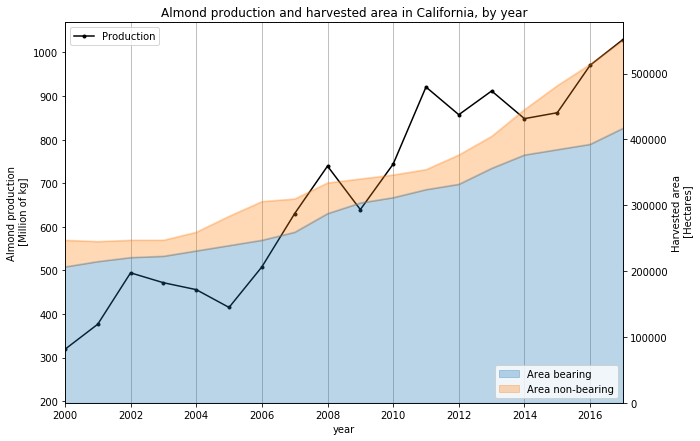

In [171]:
# Plots
fig, ax1 = plt.subplots(figsize=(10, 7))
prod_plt = california_almond.plot(x='year', y='production', style='k.-', ax=ax1, legend=True, label='Production')
ax2 = ax1.twinx()
area_plt = california_almond.plot(x='year', y=['bearing', 'non_bearing'], kind='area',stacked=True, alpha=0.3, ax=ax2, legend=True, label=['Area bearing', 'Area non-bearing'])
ax2.legend(loc='lower right')

plt.xlim(left=2000)
plt.title('Almond production and harvested area in California, by year')
ax1.grid(axis='x')
plt.xlabel('Year')
ax1.set_ylabel('Almond production\n [Million of kg]')
ax2.set_ylabel('Harvested area\n [Hectares]')
plt.show()

**Analysis**: To Do

- 2004-2005: First big case of CCD
- [2005](https://www.latimes.com/archives/la-xpm-2005-may-07-fi-almonds7-story.html)
- 2014 Drought (more in general 2011-...) but now, more water efficient trees
- [2015](https://www.bls.gov/opub/btn/volume-6/the-rise-and-fall-of-almond-prices-asia-drought-and-consumer-preference.htm)
- [Article about migratory beekeeping](https://west.stanford.edu/news/blogs/and-the-west-blog/2018/bees-for-hire-california-almonds-now-are-migratory-colonies-biggest-task)
- [Scientific article about migratory beekeeping](https://www.scientificamerican.com/article/migratory-beekeeping-mind-boggling-math/)


### 5.4 Bees

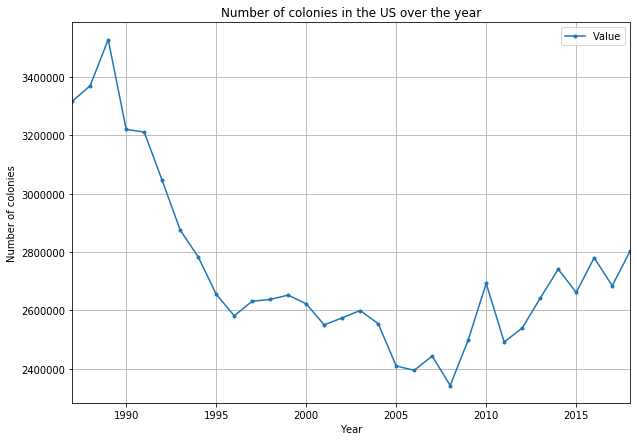

In [233]:
condition = {'Geo Level': 'NATIONAL', 'Program': 'SURVEY', 'Period': 'MARKETING YEAR'}
US_colony = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0)]
US_colony.plot(x='Year', y='Value', style='.-', figsize=(10, 7))
plt.title('Number of colonies in the US over the year')
plt.ylabel('Number of colonies')
plt.grid()
plt.show()

Idea of plot: plot bee as area ? Or maybe this plot already exists for research Q.4

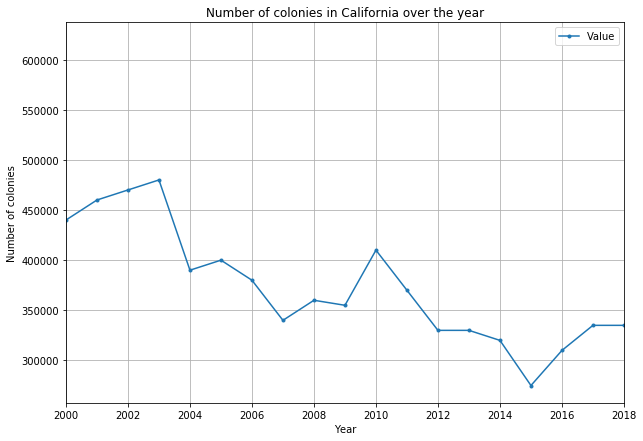

In [236]:
condition = {'Geo Level': 'STATE', 'State': 'CALIFORNIA', 'Program': 'SURVEY', 'Period': 'MARKETING YEAR'}
CAL_colony = bee_colony_df[np.all([(bee_colony_df[key] == value) for key, value in condition.items()], axis=0)]
CAL_colony.plot(x='Year', y='Value', style='.-', figsize=(10, 7))
plt.title('Number of colonies in California over the year')
plt.ylabel('Number of colonies')
plt.xlim(left=2000)
plt.grid()
plt.show()

Definitely not enough bees in California to cover the need in bees (we have seen that it requires 1.5 million colonies)